# Motivational Qualities of Songs for Daily Activities

In this assignment you will work on a study on song features and how they can be used as the basis for recommendations for specific daily activities. The study is:

* Kim, Y., Aiello, L.M. & Quercia, D. PepMusic: motivational qualities of songs for daily activities. EPJ Data Sci. 9, 13 (2020). https://doi.org/10.1140/epjds/s13688-020-0221-9

You can download the study from the above link. You can use the dataset provided by the authors, which is available inside the present folder at [data_archive_20190201.json](./data_archive_20190201.json).

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr

### Clustering 

Perform clustering on the songs, using KMeans. The authors identify the optimum number of clusters by using the elbow method (gives four clusters) and the silhouette score (gives two) clusters and taking their average, i.e., three clusters.

Using both methods, like the authors, checking the results, and then using three clusters. Visualizing the clusters by using PCA on two dimensions.

Note that the data given by the authors contain the results of their clustering. Of course this will not be a feature that we will use for our clustering. The features we will use for clustering will be:

* `chordsScale`

* `chordsKey`

* `bpm`

* `rhythmHist`

* `regularity`

* `rhythmPattern`

* `keyKey`

* `loudness`

* `pitchBiHist`

* `keyScale`

Not all of these features are atomic, and not all of these features are numerical, so we make the necessary transformations in the data so that we get all features in a single two-dimensional matrix.


In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
#!pip install yellowbrick

In [3]:
# Reading data
features_dicts = pd.DataFrame(
    pd.read_json("data_archive_20190201.json", orient="index")["features"]
)

# Normalizing the JSON object and creating a DataFrame
df_features = pd.json_normalize(features_dicts.features)

In [4]:
# combining music keys and scales into two columns
df_features["musicKey"] = df_features["keyKey"] + " " + df_features["keyScale"]
df_features["musicChord"] = df_features["chordsKey"] + " " + df_features["chordsScale"]

In [5]:
# Create a list to hold the new columns
new_columns = []

for i in range(len(df_features["rhythmHist"][0])):
    # Set the column name as 'Column i' where i is the loop counter
    column_name = "rhythmHist " + str(i)

    # Create a new DataFrame with the column name and data
    new_column = pd.DataFrame(
        {column_name: df_features["rhythmHist"].apply(lambda x: x[i])}
    )
    # Add the new DataFrame to the list of new columns
    new_columns.append(new_column)

for i in range(len(df_features["rhythmPattern"][0])):
    # Set the column name as 'Column i' where i is the loop counter
    column_name = "rhythmPattern " + str(i)

    # Create a new DataFrame with the column name and data
    new_column = pd.DataFrame(
        {column_name: df_features["rhythmPattern"].apply(lambda x: x[i])}
    )
    # Add the new DataFrame to the list of new columns
    new_columns.append(new_column)

# Use pd.concat to add all of the new columns to the original DataFrame at once
df_features = pd.concat([df_features, *new_columns], axis=1)

In [6]:
# # One hot encoding for chordsScale column

musicChord_one_hot_encoding = pd.get_dummies(
    df_features["musicChord"], prefix="musicChord"
)

musicKey_one_hot_encoding = pd.get_dummies(df_features["musicKey"], prefix="musicKey")

# Joining with the original data frame
df_features = df_features.join(musicChord_one_hot_encoding)
df_features = df_features.join(musicKey_one_hot_encoding)

df_features.drop("chordsScale", axis=1, inplace=True)
df_features.drop("chordsKey", axis=1, inplace=True)
df_features.drop("keyScale", axis=1, inplace=True)
df_features.drop("keyKey", axis=1, inplace=True)
df_features.drop("musicChord", axis=1, inplace=True)
df_features.drop("musicKey", axis=1, inplace=True)

In [7]:
# setting pitchBiHist numeric list to its mean
df_features_copy = df_features.copy()
df_features_copy["mean_pitchBiHist"] = df_features["pitchBiHist"].apply(
    lambda x: np.mean(x[0])
)

df_features_copy.drop(
    ["rhythmHist", "rhythmPattern", "pitchBiHist"], axis=1, inplace=True
)
df_features = df_features_copy

In [8]:
# We will use `StandardScaler()` to transform the data so that all features have similar variance.
df_features.describe()

,bpm,regularity,loudness,rhythmHist 0,rhythmHist 1,rhythmHist 2,rhythmHist 3,rhythmHist 4,rhythmHist 5,rhythmHist 6,...,musicKey_E minor,musicKey_F major,musicKey_F minor,musicKey_F# major,musicKey_F# minor,musicKey_G major,musicKey_G minor,musicKey_G# major,musicKey_G# minor,mean_pitchBiHist
count,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,...,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000
mean,117.477065,1.159006,-12.095607,13.887306,11.710465,10.183916,9.167831,8.549167,8.006957,7.254479,...,0.016260,0.122855,0.034327,0.030714,0.012647,0.065041,0.007227,0.032520,0.009937,0.019729
std,24.826923,0.182544,4.783767,4.962103,4.177989,3.773217,3.680480,3.576553,3.164316,2.902491,...,0.126532,0.328419,0.182150,0.172619,0.111795,0.246709,0.084741,0.177458,0.099232,0.034637
min,61.555088,0.762386,-45.627960,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001430
25%,97.016396,1.033875,-14.128941,10.663329,8.989994,7.691335,6.796640,6.217583,5.924269,5.354671,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010973
50%,117.178268,1.137930,-10.811502,13.822461,11.922362,10.276716,9.200914,8.516446,8.141616,7.310569,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014700
75%,133.443306,1.248304,-8.907087,17.115889,14.486204,12.515982,11.328506,10.497755,10.031920,8.918465,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020628
max,184.570847,2.348065,-4.172832,34.819997,26.294767,22.423229,35.272854,26.010950,20.849600,18.517778,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.459300


In [9]:
# applying standard scaler to dataframe
scaler = StandardScaler()
fitted_features = scaler.fit_transform(df_features)
scaled_features = pd.DataFrame(
    fitted_features, index=df_features.index, columns=df_features.columns
)
scaled_features.describe()

,bpm,regularity,loudness,rhythmHist 0,rhythmHist 1,rhythmHist 2,rhythmHist 3,rhythmHist 4,rhythmHist 5,rhythmHist 6,...,musicKey_E minor,musicKey_F major,musicKey_F minor,musicKey_F# major,musicKey_F# minor,musicKey_G major,musicKey_G minor,musicKey_G# major,musicKey_G# minor,mean_pitchBiHist
count,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,...,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03,1.107000e+03
mean,1.100194e-16,5.081753e-16,2.112884e-16,1.914558e-16,2.384924e-16,3.765933e-17,-1.420123e-16,-8.635068e-16,1.948156e-17,-6.055705e-17,...,-1.123261e-16,-7.024392e-16,6.325864e-16,4.443399e-16,6.009947e-17,4.853089e-16,-8.068674e-16,-2.331769e-16,-1.539720e-16,-8.168714e-17
std,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,...,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00,1.000452e+00
min,-2.253491e+00,-2.173712e+00,-7.012780e+00,-2.799894e+00,-2.804108e+00,-2.700162e+00,-2.491998e+00,-2.391355e+00,-2.531465e+00,-2.500450e+00,...,-1.285649e-01,-3.742483e-01,-1.885398e-01,-1.780080e-01,-1.131759e-01,-2.637522e-01,-8.531908e-02,-1.833397e-01,-1.001823e-01,-5.285433e-01
25%,-8.245048e-01,-6.857916e-01,-4.252408e-01,-6.500136e-01,-6.514379e-01,-6.608970e-01,-6.445524e-01,-6.522028e-01,-6.584772e-01,-6.548396e-01,...,-1.285649e-01,-3.742483e-01,-1.885398e-01,-1.780080e-01,-1.131759e-01,-2.637522e-01,-8.531908e-02,-1.833397e-01,-1.001823e-01,-2.529115e-01
50%,-1.204063e-02,-1.155043e-01,2.685511e-01,-1.307386e-02,5.074040e-02,2.460562e-02,8.992908e-03,-9.152904e-03,4.257463e-02,1.933366e-02,...,-1.285649e-01,-3.742483e-01,-1.885398e-01,-1.780080e-01,-1.131759e-01,-2.637522e-01,-8.531908e-02,-1.833397e-01,-1.001823e-01,-1.452587e-01
75%,6.433925e-01,4.894092e-01,6.668304e-01,6.509424e-01,6.646723e-01,6.183372e-01,5.873287e-01,5.450690e-01,6.402262e-01,5.735550e-01,...,-1.285649e-01,-3.742483e-01,-1.885398e-01,-1.780080e-01,-1.131759e-01,-2.637522e-01,-8.531908e-02,-1.833397e-01,-1.001823e-01,2.596899e-02
max,2.703682e+00,6.516753e+00,1.656928e+00,4.220419e+00,3.492324e+00,3.245201e+00,7.096036e+00,4.884500e+00,4.060419e+00,3.882317e+00,...,7.778175e+00,2.672023e+00,5.303921e+00,5.617724e+00,8.835804e+00,3.791438e+00,1.172071e+01,5.454356e+00,9.981802e+00,1.269670e+01


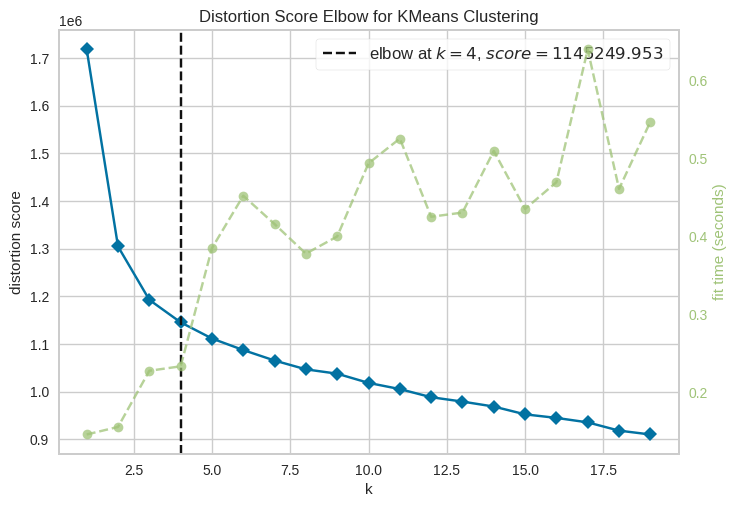

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Instantiate the KMeans algorithm with a random state of 0
kmeans = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the KMeans algorithm
# and a range of possible number of clusters (1 to 20)
visualizer = KElbowVisualizer(kmeans, k=(1, 20))

# Fit the visualizer to the scaled feature set
visualizer.fit(scaled_features)

# Show the visualizer
visualizer.show()

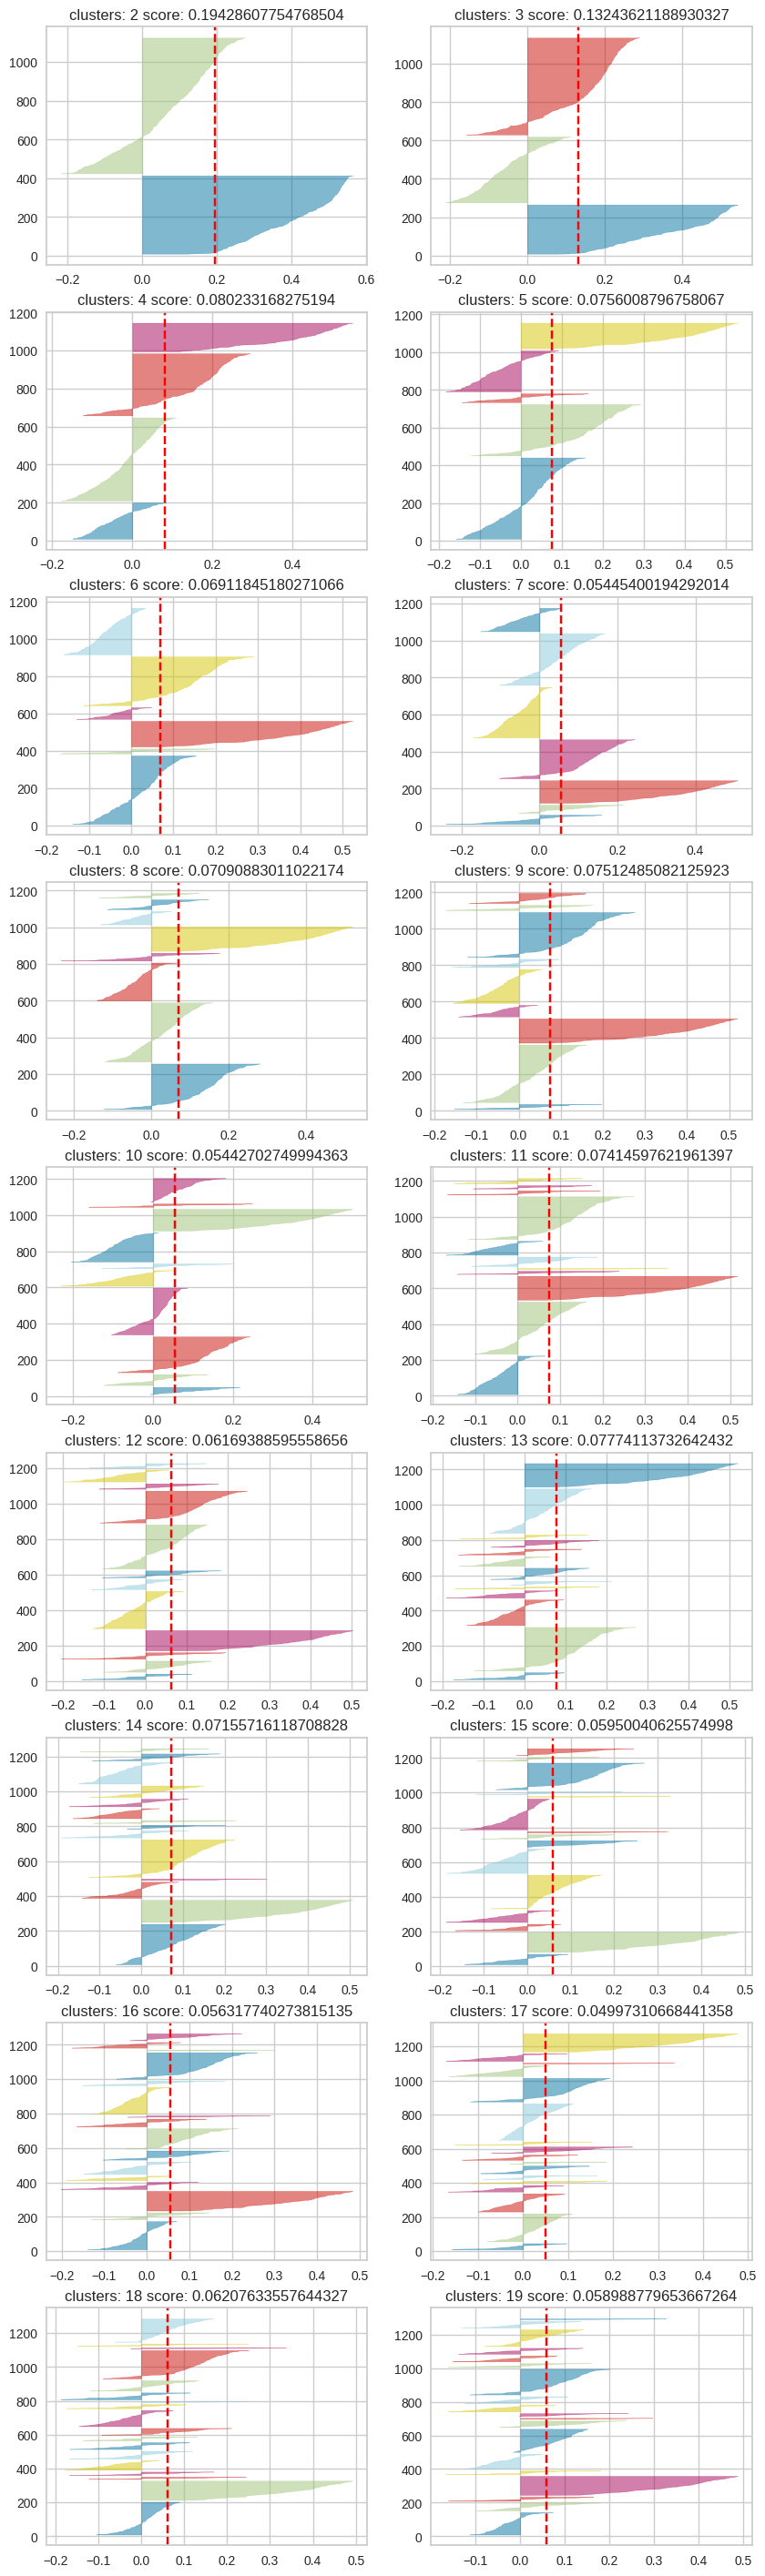

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(2 * 5, 10 * 4))

scores = {}
# Running SilhouetteVisualizer to determine number of cluster
for n_clusters in range(2, 20):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors="yellowbrick")
    visualizer.fit(scaled_features)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f"clusters: {n_clusters} score: {visualizer.silhouette_score_}")

In [12]:
# Silhouette scores
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.19428607754768504),
 (3, 0.13243621188930327),
 (4, 0.080233168275194),
 (13, 0.07774113732642432),
 (5, 0.0756008796758067),
 (9, 0.07512485082125923),
 (11, 0.07414597621961397),
 (14, 0.07155716118708828),
 (8, 0.07090883011022174),
 (6, 0.06911845180271066),
 (18, 0.06207633557644327),
 (12, 0.06169388595558656),
 (15, 0.05950040625574998),
 (19, 0.058988779653667264),
 (16, 0.056317740273815135),
 (7, 0.05445400194292014),
 (10, 0.05442702749994363),
 (17, 0.04997310668441358)]

In [13]:
# KMeans with 3 number of clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_features)

In [14]:
from sklearn.decomposition import PCA

# Instantiating the PCA object with n_components=2
pca = PCA(n_components=2)

# Fiting the PCA on the scaled feature set and transform it
X = pca.fit_transform(scaled_features)

pca.explained_variance_ratio_

array([0.36754769, 0.03862532])

<AxesSubplot:>

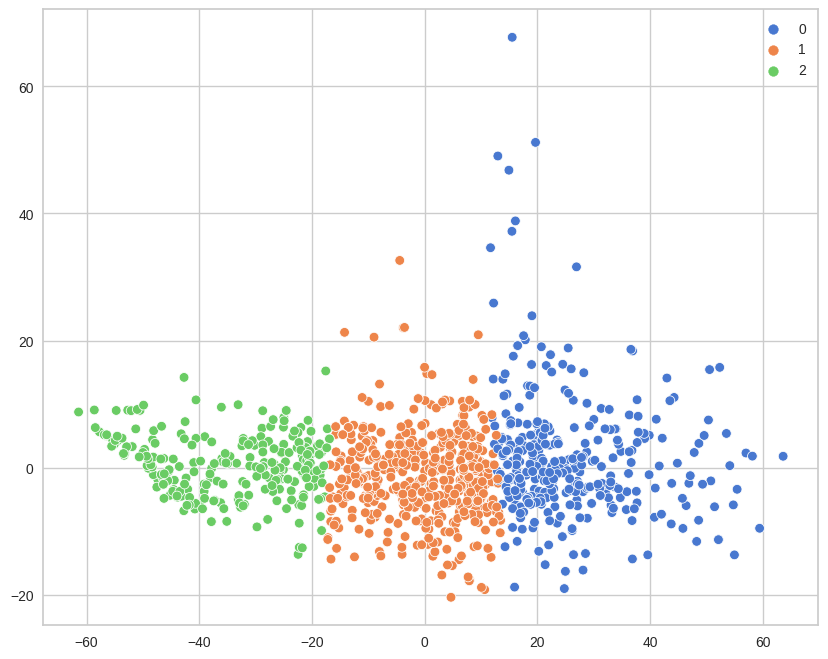

In [15]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=kmeans.labels_,
    palette=sns.color_palette("muted", n_colors=3),
)

In [16]:
df_features = df_features.join(
    pd.DataFrame(
        pd.read_json("data_archive_20190201.json", orient="index")[
            ["clusteringLabel", "activityType", "songTitle"]
        ]
    )
)

In [17]:
from sklearn import metrics

# adding kmeans labels (our clustering labels) to the data frame
df_features["kmeans_labels"] = kmeans.labels_
df_features["kmeans_labels"] = df_features["kmeans_labels"].replace(
    {0: "intense", 1: "vibrant", 2: "calm"}
)

In [18]:
# percentage of correct clustering

true_value_counts = (
    df_features["kmeans_labels"].eq(df_features.clusteringLabel).value_counts()[0]
)
true_value_counts / len(df_features.index)

0.4643179765130985

In [19]:
scaled_features = scaled_features.join(
    pd.DataFrame(
        pd.read_json("data_archive_20190201.json", orient="index")[
            ["clusteringLabel", "activityType"]
        ]
    )
)

# adding kmeans labels (our clustering labels) to the scaled data frame
scaled_features["kmeans_labels"] = kmeans.labels_

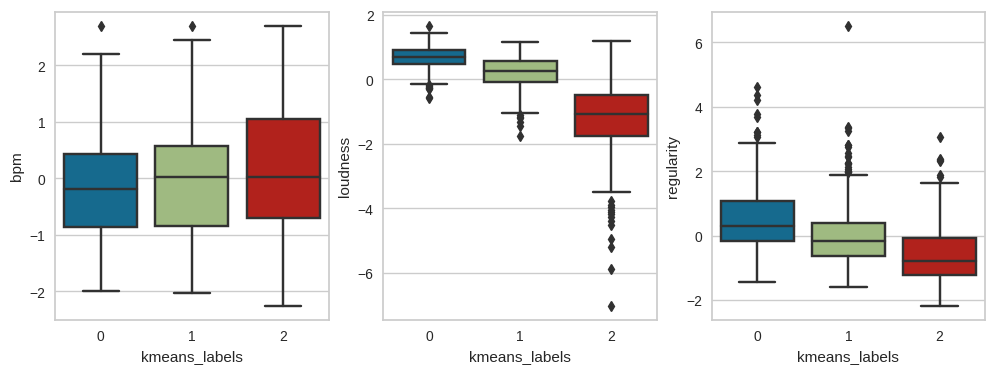

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1 = sns.boxplot(y="bpm", x="kmeans_labels", data=scaled_features, ax=ax1)

ax2 = sns.boxplot(y="loudness", x="kmeans_labels", data=scaled_features, ax=ax2)

ax2 = sns.boxplot(y="regularity", x="kmeans_labels", data=scaled_features, ax=ax3)

In [21]:
def radar_factory(keys, values, axes=None, fontsize=12):

    import math

    if axes is None:
        # Initialise the spider plot.
        plt.figure(figsize=(5, 5))
        ax = plt.subplot(111, polar=True)
    else:
        ax = axes

    num_categories = len(keys)

    # What will be the angle of each axis in the plot?
    # We divide the plot / number of variables + 1.
    # We add one because we want to do a complete circle.
    angles = np.arange(num_categories + 1)
    angles = angles / num_categories * 2 * np.pi
    angles[-1] = angles[0]

    # We want the first axis to be on top.
    ax.set_theta_offset(np.pi / 2)
    # Theta direction is -1 clockwise,
    # and 1 counterclockwise
    ax.set_theta_direction(-1)

    # Draw one axis per variable and add x labels
    ax.tick_params(labelsize=fontsize)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(keys)

    # Draw y labels
    ax.set_rlabel_position(0)
    max_y = max(values)
    min_y = min(values)

    values.append(values[0])
    ax.plot(list(angles), values, linewidth=1, linestyle="solid")

    ax.fill(angles, values, "b", alpha=0.1)
    yticks = ax.get_yticks()
    ax.set_yticklabels([])
    ylims = ax.get_ylim()
    ax.set_ylim(min(yticks[0], ylims[0]), max(yticks[-1], ylims[1]))

In [22]:
matrix_scaler = lambda a: (a - a.min()) / (a.max() - a.min())

In [23]:
cluster_centers = matrix_scaler(kmeans.cluster_centers_)

In [24]:
scaled_features

,bpm,regularity,loudness,rhythmHist 0,rhythmHist 1,rhythmHist 2,rhythmHist 3,rhythmHist 4,rhythmHist 5,rhythmHist 6,...,musicKey_F# major,musicKey_F# minor,musicKey_G major,musicKey_G minor,musicKey_G# major,musicKey_G# minor,mean_pitchBiHist,clusteringLabel,activityType,kmeans_labels
0,-0.503090,0.521998,0.641781,0.593016,0.469554,0.585460,0.396628,1.506904,0.401078,0.702609,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,0.349832,intense,exercising,0
1,0.244633,0.911432,1.105036,1.461192,1.661644,1.645697,0.689859,0.595153,1.404674,0.820539,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,-0.140113,intense,exercising,0
2,-0.574873,-1.153291,0.104218,-0.752849,-1.372743,-0.997647,-1.213328,-1.342302,-1.619445,-1.502657,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,-0.526326,calm,relaxing,2
3,-0.037192,-0.803868,0.097950,1.406796,0.589250,0.037568,-0.148586,-0.689337,-0.458882,-0.352276,...,-0.178008,-0.113176,3.791438,-0.085319,-0.183340,-0.100182,-0.442758,calm,relaxing,2
4,1.499176,-0.450345,-0.037384,-0.662089,-1.520588,-1.513635,-1.606456,-1.473321,-1.494973,-1.342603,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,-0.514147,calm,relaxing,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.227675,-1.103292,-0.203021,0.902021,1.150683,0.971311,0.288857,0.578721,0.573963,0.146093,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,-0.195256,vibrant,dinner,1
1103,-0.313884,-0.088072,0.147535,-0.408668,-0.322667,-0.220070,-0.504376,-0.625551,-0.599756,-0.453512,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,-0.145259,vibrant,dinner,1
1104,0.321840,-0.925935,0.156199,1.875811,1.888089,2.314275,1.322409,1.246073,0.627487,0.896962,...,-0.178008,-0.113176,-0.263752,-0.085319,5.454356,-0.100182,-0.148982,vibrant,dinner,1
1105,-1.350547,-0.273072,0.577714,0.401400,1.033130,0.680077,1.809883,0.213009,0.988601,0.900442,...,-0.178008,-0.113176,-0.263752,-0.085319,-0.183340,-0.100182,-0.333450,vibrant,dinner,0


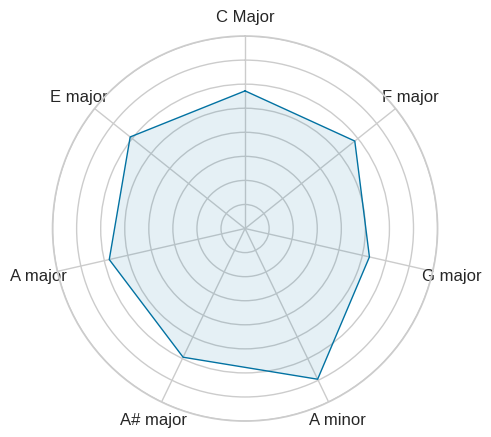

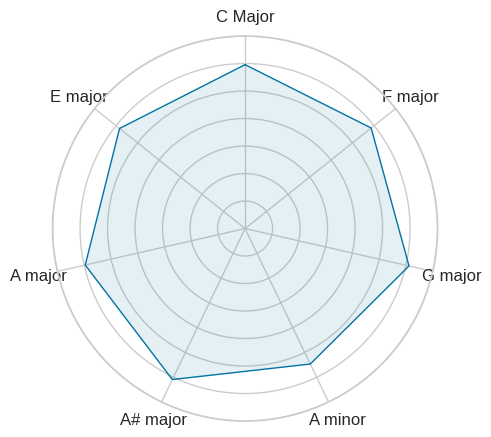

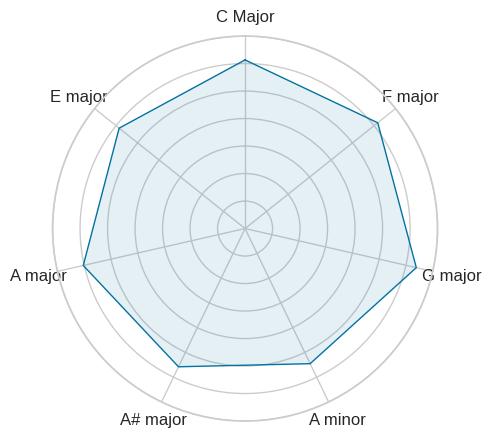

In [25]:
keys = [
    "musicKey_C major",
    "musicKey_F major",
    "musicKey_G major",
    "musicKey_A minor",
    "musicKey_A# major",
    "musicKey_A major",
    "musicKey_E major",
]
values = []
for i in range(7):
    values.append(
        scaled_features.drop(
            ["kmeans_labels", "clusteringLabel", "activityType"], axis=1
        ).columns.get_loc(keys[i])
    )
keys = ["C Major", "F major", "G major", "A minor", "A# major", "A major", "E major"]
list_val = []
for i in range(3):
    for j in range(7):
        list_val.append(cluster_centers[i][values[j]])
    radar_factory(keys, list_val)
    list_val = []

### Classification

Following the classification, the authors build a classifier to predict the class (defined as the cluster) of a song. The authors build their classifier using Random Forests and they use a series of models, described in Table 3. 

Beyond the tree-based classifiers, we proceed to build a neural-network classifier using PyTorch.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
#!pip install torch

In [28]:
cols_not_needed = ["activityType", "songTitle", "clusteringLabel"]

In [29]:
df_features = df_features.drop(columns=cols_not_needed)

In [30]:
feature_cols = [col for col in df_features.columns if col != "kmeans_labels"]

In [31]:
feature_cols_with_out_hist = [
    col
    for col in df_features.columns
    if (not "rhythm" in col)
    and (not "mean_pitchBiHist" in col)
    and (col != "kmeans_labels")
]

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X = df_features[feature_cols]
y = df_features["kmeans_labels"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train a Random Forest classifier on each individual feature
# Create a new Random Forest classifier
clf = RandomForestClassifier(random_state=42)
ovr = OneVsRestClassifier(clf)

csfr_dict = {}
for feature in feature_cols:

    # fitting classifier
    ovr.fit(X_train[[feature]], y_train)

    # Evaluate the model using cross-validation
    score = cross_val_score(ovr, X_test[[feature]], y_test, cv=10)

    y_pred = cross_val_predict(ovr, X_test[[feature]], y_test, cv=10)

    csfr_dict[feature] = classification_report(y_test, y_pred, output_dict=True)

#   accuracy = accuracy_score(y_test[y_test == cluster], y_pred[y_test == cluster])

df_scores = pd.DataFrame(csfr_dict)

/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/an

/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/an

/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/an

/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/an

/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandros/an

In [33]:
X_no_hist = df_features[feature_cols_with_out_hist]
y = df_features["kmeans_labels"]
X_train, X_test, y_train, y_test = train_test_split(
    X_no_hist, y, test_size=0.3, random_state=42
)

# Train a Random Forest classifier on each individual feature
# Create a new Random Forest classifier
clf_2 = RandomForestClassifier(random_state=42)
ovr_2 = OneVsRestClassifier(clf_2)


# fitting classifier
ovr_2.fit(X_train.loc[:, feature_cols_with_out_hist], y_train)

# Evaluate the model using cross-validation
scores = cross_val_score(
    ovr_2, X_test.loc[:, feature_cols_with_out_hist], y_test, cv=10
)

y_pred = cross_val_predict(ovr_2, X_test, y_test, cv=10)

df_scores_no_hist = pd.DataFrame(
    classification_report(y_test, y_pred, output_dict=True)
)

In [34]:
X_all = df_features[feature_cols]
y = df_features["kmeans_labels"]
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.3, random_state=42
)

# Train a Random Forest classifier on each individual feature
# Create a new Random Forest classifier
clf_3 = RandomForestClassifier(random_state=42)
ovr_3 = OneVsRestClassifier(clf_3)

# fitting classifier
ovr_3.fit(X_train.loc[:, feature_cols], y_train)

# Evaluate the model using cross-validation
scores = cross_val_score(ovr_3, X_test.loc[:, feature_cols], y_test, cv=10)

y_pred = cross_val_predict(ovr_3, X_test, y_test, cv=10)

df_scores_all = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

In [35]:
no_hist_accuracy = df_scores_no_hist["accuracy"][0:3]
df_scores_no_hist = df_scores_no_hist.T.rename(
    index={
        "calm": "calm no hist",
        "vibrant": "vibrant no hist",
        "intense": "intense no hist",
    }
)
df_scores_no_hist = df_scores_no_hist.drop(
    index=["macro avg", "weighted avg", "accuracy"]
)
df_scores_no_hist["accuracy"] = no_hist_accuracy.values

In [36]:
all_accuracy = df_scores_all["accuracy"][0:3]
df_scores_all = df_scores_all.T.rename(
    index={"calm": "calm all", "vibrant": "vibrant all", "intense": "intense all"}
)
df_scores_all = df_scores_all.drop(index=["macro avg", "weighted avg", "accuracy"])
df_scores_all["accuracy"] = all_accuracy.values

In [37]:
table_3_cols = ["accuracy", "precision", "f1-score", "recall"]
df_table_3 = pd.DataFrame(columns=table_3_cols)

regularity_calm = df_scores["regularity"]["calm"]
regularity_calm["accuracy"] = df_scores["regularity"]["accuracy"]
regularity_intense = df_scores["regularity"]["intense"]
regularity_intense["accuracy"] = df_scores["regularity"]["accuracy"]
regularity_vibrant = df_scores["regularity"]["vibrant"]
regularity_vibrant["accuracy"] = df_scores["regularity"]["accuracy"]

bpm_calm = df_scores["bpm"]["calm"]
bpm_calm["accuracy"] = df_scores["bpm"]["accuracy"]
bpm_intense = df_scores["bpm"]["intense"]
bpm_intense["accuracy"] = df_scores["bpm"]["accuracy"]
bpm_vibrant = df_scores["bpm"]["vibrant"]
bpm_vibrant["accuracy"] = df_scores["bpm"]["accuracy"]

loudness_calm = df_scores["loudness"]["calm"]
loudness_calm["accuracy"] = df_scores["loudness"]["accuracy"]
loudness_intense = df_scores["loudness"]["intense"]
loudness_intense["accuracy"] = df_scores["loudness"]["accuracy"]
loudness_vibrant = df_scores["loudness"]["vibrant"]
loudness_vibrant["accuracy"] = df_scores["loudness"]["accuracy"]


df_table_3.loc["calm Regularity"] = regularity_calm
df_table_3.loc["calm BPM"] = bpm_calm
df_table_3.loc["calm Loudness"] = loudness_calm

df_table_3.loc["vibrant Regularity"] = regularity_vibrant
df_table_3.loc["vibrant BPM"] = bpm_vibrant
df_table_3.loc["vibrant Loudness"] = loudness_vibrant

df_table_3.loc["intense Regularity"] = regularity_intense
df_table_3.loc["intense BPM"] = bpm_intense
df_table_3.loc["intense Loudness"] = loudness_intense

In [38]:
rhythmHist_cols = [col for col in df_scores.columns if col.startswith("rhythmHist")]
musicKey_cols = [col for col in df_scores.columns if col.startswith("musicKey")]
musicChord_cols = [col for col in df_scores.columns if col.startswith("musicChord")]
rhythmPattern_cols = [
    col for col in df_scores.columns if col.startswith("rhythmPattern")
]

scores_dict = {}
cols_cat = {
    "rhythmHist": rhythmHist_cols,
    "musicKey": musicKey_cols,
    "musicChord": musicChord_cols,
    "rhythmPattern": rhythmPattern_cols,
}
classes = ["calm", "intense", "vibrant"]
measures = ["precision", "recall", "f1-score", "accuracy"]
for cat_key, cat in cols_cat.items():
    for cls in classes:
        means = {}
        for measure in measures:
            if measure == "accuracy":
                mean = np.mean(df_scores[cat].apply(lambda x: x[measure], axis=0))
                means[measure] = mean
            else:
                mean = np.mean(df_scores[cat].apply(lambda x: x[cls][measure], axis=0))
                means[measure] = mean
        df_table_3.loc[f"{cls} {cat_key}"] = means

In [39]:
df_table_3 = pd.concat([df_scores_all, df_scores_no_hist, df_table_3], axis=0)
df_table_3 = df_table_3.drop(columns=["support"])

In [40]:
df_table_3 = df_table_3.reset_index()
df_table_3["class"] = df_table_3["index"].apply(lambda x: x.split(" ")[0])
df_table_3["feature"] = df_table_3["index"].apply(lambda x: x.split(" ")[1])
df_table_3.drop(columns=["index"], inplace=True)
df_table_3.sort_values(by=["class"], inplace=True)
df_table_3.set_index(["class", "feature"], inplace=True)

In [59]:
df_table_3

precision    recall  f1-score  accuracy
class   feature                                               
calm    all             0.978261  0.957447  0.967742  0.945946
        rhythmPattern   0.704160  0.705341  0.704410  0.594880
        no              0.804348  0.787234  0.795699  0.693694
        musicChord      0.056424  0.007979  0.013799  0.439439
        Regularity      0.360000  0.382979  0.371134  0.429429
        BPM             0.302326  0.276596  0.288889  0.312312
        Loudness        0.734043  0.734043  0.734043  0.576577
        musicKey        0.100877  0.010638  0.018506  0.438188
        rhythmHist      0.820911  0.823050  0.821734  0.686887
intense musicChord      0.072129  0.012545  0.021111  0.439439
        musicKey        0.076209  0.008513  0.014473  0.438188
        rhythmHist      0.598175  0.606452  0.601902  0.686887
        Loudness        0.494505  0.483871  0.489130  0.576577
        BPM             0.262626  0.279570  0.270833  0.312312
        Regularity      0.413043  0.408602  0.410811  0.429429
        no              0.655172  0.612903  0.633333  0.693694
        all             0.987952  0.881720  0.931818  0.945946
        rhythmPattern   0.517734  0.523088  0.519976  0.594880
vibrant Loudness        0.527027  0.534247  0.530612  0.576577
        BPM             0.351351  0.356164  0.353741  0.312312
        rhythmHist      0.657880  0.650457  0.653900  0.686887
        Regularity      0.489362  0.472603  0.480836  0.429429
        no              0.649351  0.684932  0.666667  0.693694
        musicKey        0.438732  0.987158  0.607428  0.438188
        all             0.905063  0.979452  0.940789  0.945946
        musicChord      0.439691  0.989155  0.608721  0.439439
        rhythmPattern   0.574620  0.569492  0.571779  0.594880

In [41]:
df = df_features.copy()
df["kmeans_labels"] = kmeans.labels_

In [42]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [43]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7
)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=15
)

In [44]:
# convert to numpy
# in order to convert to tensor later
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [45]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


# transform to tensors
train_dataset = ClassifierDataset(
    torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).long()
)
val_dataset = ClassifierDataset(
    torch.from_numpy(X_val).type(torch.float32), torch.from_numpy(y_val).long()
)
test_dataset = ClassifierDataset(
    torch.from_numpy(X_test).type(torch.float32), torch.from_numpy(y_test).long()
)

In [46]:
# model parameters
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3

In [47]:
# train_loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [48]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()

        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)

        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)

        return x

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
model = MulticlassClassification(num_feature=NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=1552, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [51]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [52]:
accuracy_stats = {"train": [], "val": []}
loss_stats = {"train": [], "val": []}

In [53]:
from tqdm.notebook import tqdm

In [54]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION
    with torch.no_grad():

        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    loss_stats["train"].append(train_epoch_loss / len(train_loader))
    loss_stats["val"].append(val_epoch_loss / len(val_loader))
    accuracy_stats["train"].append(train_epoch_acc / len(train_loader))
    accuracy_stats["val"].append(val_epoch_acc / len(val_loader))

    print(
        f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}"
    )

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.59445 | Val Loss: 0.40466 | Train Acc: 78.140| Val Acc: 86.517
Epoch 002: | Train Loss: 0.39558 | Val Loss: 0.27630 | Train Acc: 86.760| Val Acc: 89.888
Epoch 003: | Train Loss: 0.32896 | Val Loss: 0.28718 | Train Acc: 87.420| Val Acc: 88.764
Epoch 004: | Train Loss: 0.28152 | Val Loss: 0.27590 | Train Acc: 89.780| Val Acc: 89.888
Epoch 005: | Train Loss: 0.24577 | Val Loss: 0.38747 | Train Acc: 91.080| Val Acc: 83.146
Epoch 006: | Train Loss: 0.19086 | Val Loss: 0.34975 | Train Acc: 93.420| Val Acc: 86.517
Epoch 007: | Train Loss: 0.17166 | Val Loss: 0.43109 | Train Acc: 94.360| Val Acc: 79.775
Epoch 008: | Train Loss: 0.13767 | Val Loss: 0.56227 | Train Acc: 95.360| Val Acc: 80.899
Epoch 009: | Train Loss: 0.14360 | Val Loss: 0.70552 | Train Acc: 95.120| Val Acc: 80.899
Epoch 010: | Train Loss: 0.11933 | Val Loss: 0.52659 | Train Acc: 95.940| Val Acc: 79.775
Epoch 011: | Train Loss: 0.08057 | Val Loss: 0.51575 | Train Acc: 97.960| Val Acc: 84.270
Epoch 012:

Epoch 092: | Train Loss: 0.00039 | Val Loss: 0.54888 | Train Acc: 100.000| Val Acc: 89.888
Epoch 093: | Train Loss: 0.00035 | Val Loss: 0.55963 | Train Acc: 100.000| Val Acc: 89.888
Epoch 094: | Train Loss: 0.00036 | Val Loss: 0.58543 | Train Acc: 100.000| Val Acc: 88.764
Epoch 095: | Train Loss: 0.00042 | Val Loss: 0.58236 | Train Acc: 100.000| Val Acc: 88.764
Epoch 096: | Train Loss: 0.00029 | Val Loss: 0.57853 | Train Acc: 100.000| Val Acc: 88.764
Epoch 097: | Train Loss: 0.00031 | Val Loss: 0.58891 | Train Acc: 100.000| Val Acc: 88.764
Epoch 098: | Train Loss: 0.00027 | Val Loss: 0.59475 | Train Acc: 100.000| Val Acc: 88.764
Epoch 099: | Train Loss: 0.00033 | Val Loss: 0.57625 | Train Acc: 100.000| Val Acc: 89.888
Epoch 100: | Train Loss: 0.00031 | Val Loss: 0.55349 | Train Acc: 100.000| Val Acc: 89.888
Epoch 101: | Train Loss: 0.00027 | Val Loss: 0.56190 | Train Acc: 100.000| Val Acc: 88.764
Epoch 102: | Train Loss: 0.00028 | Val Loss: 0.62682 | Train Acc: 100.000| Val Acc: 88.764

Epoch 183: | Train Loss: 0.00067 | Val Loss: 0.57933 | Train Acc: 100.000| Val Acc: 87.640
Epoch 184: | Train Loss: 0.00055 | Val Loss: 0.57238 | Train Acc: 100.000| Val Acc: 87.640
Epoch 185: | Train Loss: 0.00051 | Val Loss: 0.57639 | Train Acc: 100.000| Val Acc: 86.517
Epoch 186: | Train Loss: 0.00061 | Val Loss: 0.57936 | Train Acc: 100.000| Val Acc: 87.640
Epoch 187: | Train Loss: 0.00049 | Val Loss: 0.56305 | Train Acc: 100.000| Val Acc: 87.640
Epoch 188: | Train Loss: 0.00052 | Val Loss: 0.58243 | Train Acc: 100.000| Val Acc: 87.640
Epoch 189: | Train Loss: 0.00052 | Val Loss: 0.59184 | Train Acc: 100.000| Val Acc: 87.640
Epoch 190: | Train Loss: 0.00037 | Val Loss: 0.57625 | Train Acc: 100.000| Val Acc: 87.640
Epoch 191: | Train Loss: 0.00041 | Val Loss: 0.60288 | Train Acc: 100.000| Val Acc: 87.640
Epoch 192: | Train Loss: 0.00041 | Val Loss: 0.60117 | Train Acc: 100.000| Val Acc: 87.640
Epoch 193: | Train Loss: 0.00032 | Val Loss: 0.60838 | Train Acc: 100.000| Val Acc: 87.640

Epoch 274: | Train Loss: 0.00011 | Val Loss: 0.52072 | Train Acc: 100.000| Val Acc: 91.011
Epoch 275: | Train Loss: 0.00015 | Val Loss: 0.55745 | Train Acc: 100.000| Val Acc: 91.011
Epoch 276: | Train Loss: 0.00016 | Val Loss: 0.54995 | Train Acc: 100.000| Val Acc: 91.011
Epoch 277: | Train Loss: 0.00013 | Val Loss: 0.54338 | Train Acc: 100.000| Val Acc: 89.888
Epoch 278: | Train Loss: 0.00010 | Val Loss: 0.54222 | Train Acc: 100.000| Val Acc: 92.135
Epoch 279: | Train Loss: 0.00011 | Val Loss: 0.54891 | Train Acc: 100.000| Val Acc: 92.135
Epoch 280: | Train Loss: 0.00011 | Val Loss: 0.54981 | Train Acc: 100.000| Val Acc: 92.135
Epoch 281: | Train Loss: 0.00012 | Val Loss: 0.53649 | Train Acc: 100.000| Val Acc: 92.135
Epoch 282: | Train Loss: 0.00011 | Val Loss: 0.56396 | Train Acc: 100.000| Val Acc: 91.011
Epoch 283: | Train Loss: 0.00010 | Val Loss: 0.54694 | Train Acc: 100.000| Val Acc: 91.011
Epoch 284: | Train Loss: 0.00009 | Val Loss: 0.54340 | Train Acc: 100.000| Val Acc: 91.011

In [55]:
# testing accuracy in testing dataset

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [56]:
# 0: "intense", 1: "vibrant", 2: "calm"
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90        69
           1       0.88      0.93      0.90       101
           2       0.94      0.92      0.93        52

    accuracy                           0.91       222
   macro avg       0.92      0.91      0.91       222
weighted avg       0.91      0.91      0.91       222



### Using XGBoost

In [57]:
import xgboost as xgb

# Instantiate an XGBClassifier object
xg = xgb.XGBClassifier()

# Fit the classifier to the training data
xg.fit(X_train, y_train)

# Make predictions on the validation set
pred = xg.predict(X_val)

# Print the classification report
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       0.93      1.00      0.96        41
           2       1.00      0.95      0.97        20

    accuracy                           0.97        89
   macro avg       0.98      0.96      0.97        89
weighted avg       0.97      0.97      0.97        89

